In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor


# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
%matplotlib inline
%load_ext watermark
%load_ext autoreload 
%autoreload 2

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,xgboost,sklearn

Ethen 2017-03-13 16:36:50 

CPython 3.5.2
IPython 4.2.0

numpy 1.12.0
pandas 0.19.2
matplotlib 2.0.0
xgboost 0.6
sklearn 0.18


/Users/ethen/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


http://archive.ics.uci.edu/ml/datasets/Automobile

http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names

In [2]:
def read_dataset(filename):
    """
    pass in the filename and read in the dataset, if the dataset is
    not found in the current folder, we will fetch it from the website
    """
    if not os.path.exists(filename):
        url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data'
        df = pd.read_csv(url, header = None, na_values = ['?'])
        colnames = ['symboling', 'normalized-losses', 'make', 'fuel-type', 
                    'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 
                    'engine-location', 'wheel-base', 'length', 'width', 'height',
                    'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size',
                    'fuel-system', 'bore', 'stroke', 'compression-ratio',
                    'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
        df.columns = colnames
        df.to_csv(filename, index = False)

    df = pd.read_csv(filename)
    return df

In [3]:
filename = 'auto.csv'
df = read_dataset(filename)
print(df.shape)
df.head()

(205, 26)


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [4]:
df.isnull().sum(axis = 0)

symboling             0
normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [5]:
# there were very few missing records for these columns, thus
# we drop them to prevent biasing the data with imputation 
# (only 12 rows were removed)
subset = ['num-of-doors', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price']
df = df.dropna(subset = subset)
df.shape

(193, 26)

In [6]:
# number of missing values per row
np.bincount( df.isnull().sum(axis = 1) )

array([159,  34])

1. mice
2. partial dependence plot

In [7]:
# normalized-losses, drop due to lots of missing values
# make drop due to having too many distinct categorical variables
df = df.drop(['normalized-losses', 'make'], axis = 1)
df.head()

,symboling,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [8]:
# extract the response/output column
response_col = 'price'
y = df[response_col].values
df = df.drop(response_col, axis = 1)

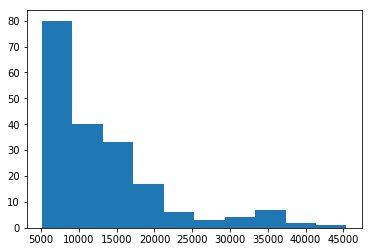

In [9]:
plt.hist(y)
plt.show()

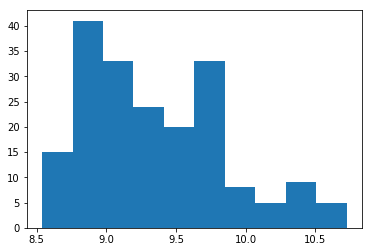

In [16]:
plt.hist(np.log(y))
plt.show()

In [10]:
# categorical variables: one-hot-encode them
# numeric variables : standardize and remove multicollinearity using VIF
cat_cols = ['symboling', 'fuel-type', 'aspiration', 'num-of-doors', 
            'body-style', 'drive-wheels', 'engine-location', 'fuel-system',
            'engine-type', 'num-of-cylinders']
num_cols = list(set(df.columns) - set(cat_cols))

for col in cat_cols:
    df[col] = df[col].astype('category')

dummied = pd.get_dummies(df[cat_cols], drop_first = True)
X = pd.concat([df[num_cols], dummied], axis = 1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

In [11]:
num_X_train = X_train[:, :len(num_cols)]
num_X_test = X_test[:, :len(num_cols)]
scaler = StandardScaler()
X_train[:, :len(num_cols)] = scaler.fit_transform(num_X_train)
X_test[:, :len(num_cols)] = scaler.transform(num_X_test)

The function being plotted is defined as:

$$\tilde{f}(x) = \frac{1}{n} ∑_{i=1}^n f(x, x_{iC})$$

where x is the variable for which partial dependence is sought, and $x_{iC}$ is the other variables in the data. The summand is the predicted regression function for regression, and logits (i.e., log of fraction of votes) for which.class for classification:

$$f(x) = \log p_k(x) - \frac{1}{K} ∑_{j=1}^K \log p_j(x)$$

where K is the number of classes, k is which.class, and p_j is the proportion of votes for class j.

In [12]:
def remove_collinearity(X_train, X_test, num_cols, threshold):
    """
    identify multi-collinearity between the numeric variables 
    using variance inflation factor (vif), remove them from both 
    the train and test set and returns the list of columns that have 
    been removed; conventionally, a vif score larger than 5 should be
    removed; the value can be specified by the threshold argument
    """
    finished = False
    removed_cols = []
    
    while not finished:
        vif = [ variance_inflation_factor(X_train, ix) 
                for ix in range(X_train.shape[1]) ]
        max_index = np.argmax(vif)

        if vif[max_index] >= threshold:
            removed = num_cols[max_index]
            removed_cols.append(removed)
            num_cols.remove(removed)
            X_train = np.delete(X_train, max_index, axis = 1)
            X_test = np.delete(X_test, max_index, axis = 1)
        else:
            finished = True
    
    return X_train, X_test, removed_cols

In [13]:
threshold = 5
num_X_train, num_X_test, removed_cols = remove_collinearity(num_X_train, num_X_test, 
                                                            num_cols, threshold)

In [14]:
removed_cols

['city-mpg', 'curb-weight', 'horsepower', 'length', 'width']

In [15]:
collinear_cols = set(['city-mpg', 'curb-weight', 'horsepower', 'length', 'width'])
num_cols = list( set(df.columns) - set(cat_cols) - set(collinear_cols) )
num_cols

['highway-mpg',
 'bore',
 'engine-size',
 'wheel-base',
 'peak-rpm',
 'stroke',
 'compression-ratio',
 'height']

## Reference

- [StackExchange : How to systematically remove collinear variables in Python?](http://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-in-python)